# Comparing Model Resolution

This notebook loads and explores model solutions at a range of horizontal resolutions (1°, 0.25°, and 0.1°). We use snapshots of model output to explore how the velocity fields differ between the simulations. We will also look at eddy kinetic energy, which highlights that lower resolution simulations have less variability in their velocity fields.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cft
import IPython.display

Given that the high resolution simulations contain quite a lot of data, let's fire up a Dask cluster to parallelise the computation.

In [2]:
from dask.distributed import Client

client = Client('127.0.0.1:38079')
client

Client Scheduler: tcp://127.0.0.1:38079 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


In preparation for the plots, let's load the land for cartopy.

In [3]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

Now instantiate a database session.

In [4]:
session = cc.database.create_session()

Pick three experiments to analyse. If you want to look at a list of all the experiments available, run the following snippet.

`print(cc.querying.get_experiments(session)['experiment'].values)`

In [5]:
expts = ['01deg_jra55v13_iaf', '025deg_jra55v13_iaf_gmredi6', '1deg_jra55v13_iaf_spinup1_B1_lastcycle']
titles = ['0.1° horizontal resolution', '0.25° horizontal resolution', '1° horizontal resolution']

In [6]:
sims = {}
for exp in expts:
    u = cc.querying.getvar(exp,'u',session, ncfile='ocean.nc')
    v = cc.querying.getvar(exp,'v',session, ncfile='ocean.nc')
    speed = cc.querying.getvar(exp,'speed',session, ncfile='ocean.nc')
    eke = (u-u.mean(dim='time'))**2 + (v-v.mean(dim='time'))**2

    sims[exp] = xr.merge([u, v, speed, eke.rename('eke')])

Let's have a look at the data we just loaded into this dictionary.

In [7]:
sims

{'01deg_jra55v13_iaf': <xarray.Dataset>
 Dimensions:   (st_ocean: 75, time: 396, xu_ocean: 3600, yu_ocean: 2700)
 Coordinates:
   * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
   * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
   * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
   * time      (time) object 1985-01-14 12:00:00 ... 2017-12-14 12:00:00
 Data variables:
     u         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
     v         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
     speed     (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
     eke       (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>,
 '025deg_jra55v13_iaf_gmredi6': <xarray.Dataset>
 Dimensions:   (st_ocean: 50, 

Having loaded the data, let's plot some output from each simulation and look at the differences. The following plots are snapshots of zonal velocity. All three simulations show roughly the same results, with westward and eastward flows occuring in approximately the same locations. However, the 0.1° and 0.25° simulations show mesoscale variability that is entirely lacking from the 1° simulation.

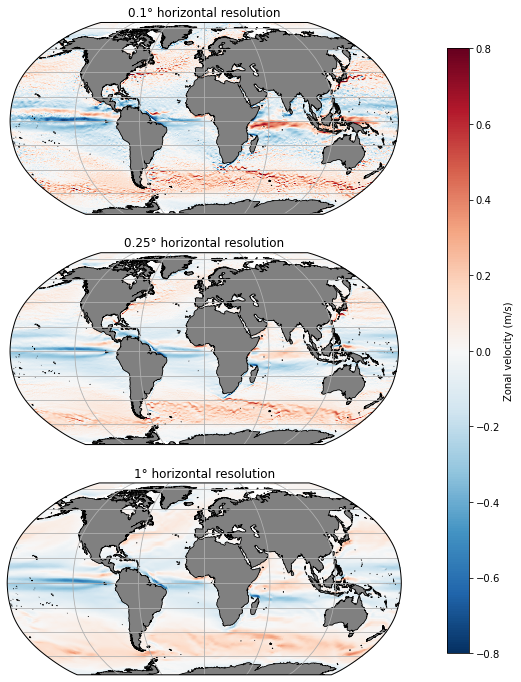

In [8]:
plt.figure(figsize=(10,12))

for counter, exp in enumerate(expts):
    ax = plt.subplot(3, 1, counter+1, projection=ccrs.Robinson(), label='{0}'.format(counter))

    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=False)
    p1 = ax.pcolormesh(sims[exp].u.xu_ocean, sims[exp].u.yu_ocean, sims[exp].u[-1,0,:,:], transform=ccrs.PlateCarree(),
                       cmap='RdBu_r', vmin=-0.8, vmax=0.8)
    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.15, 0.03, 0.7])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Zonal velocity (m/s)');


The mesoscale variability hinted at in the above global figures is more easily seen by zooming into a regional scale. The plots below show the Atlantic sector of the Southern Ocean, including the Agulhas Current, and Drake Passage. The figures below also show that higher horizontal resolution support much higher flow speeds.

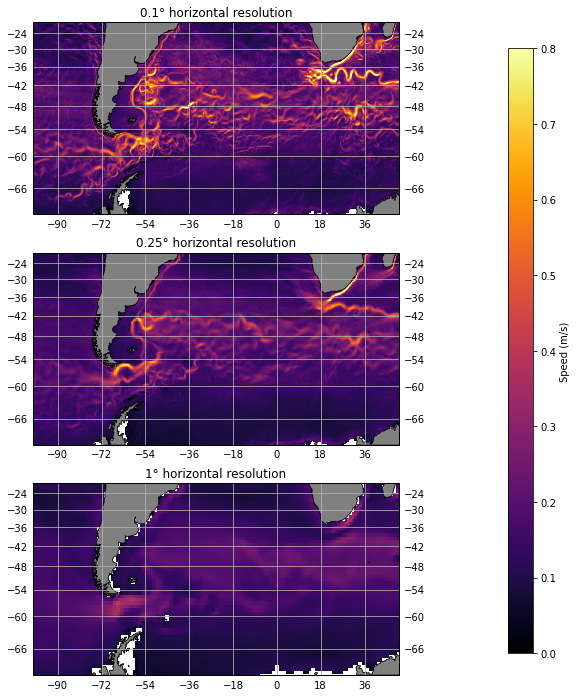

In [9]:
projection=ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

plt.figure(figsize=(12,12))

for counter, exp in enumerate(expts):
    ax = plt.subplot(3, 1, counter+1, projection=projection, label='{0}'.format(counter))
    
    ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    p1 = ax.pcolormesh(sims[exp].speed.xu_ocean, sims[exp].speed.yu_ocean, sims[exp].speed[-1,0,:,:], transform=ccrs.PlateCarree(),
                       cmap='inferno', vmin=0, vmax=0.8)
    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.15, 0.03, 0.7])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Speed (m/s)');


The higher resolution simulations exhibit much more variability in their velocity fields. This can be easily seen by looking at eddy kinetic energy, defined as 

$$(u - \overline{u})^{2} + (v-\overline{v})^{2} $$

which picks out variability in the velocity fields. This plot takes quite some time to produce, since it requires averaging the entire time series of `u` and `v` for each simulation.

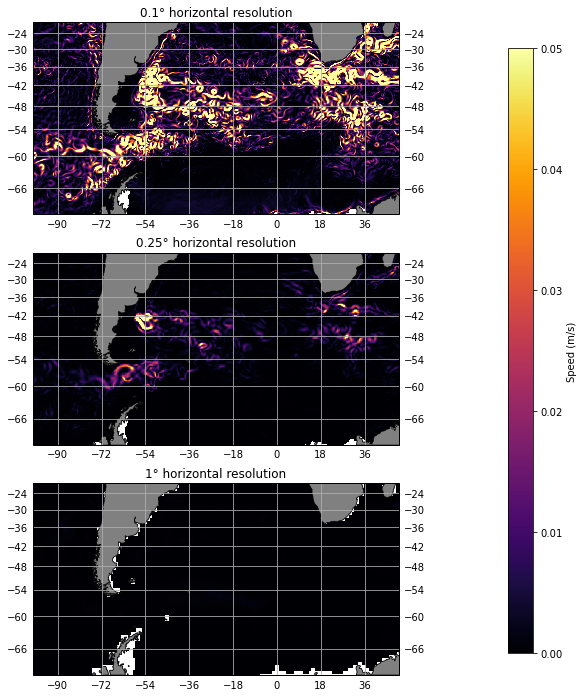

In [10]:
projection=ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

plt.figure(figsize=(12,12))

for counter, exp in enumerate(expts):
    ax = plt.subplot(3, 1, counter+1, projection=projection, label='{0}'.format(counter))
    
    ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    p1 = ax.pcolormesh(sims[exp].eke.xu_ocean, sims[exp].eke.yu_ocean, sims[exp].eke[-1,0,:,:], transform=ccrs.PlateCarree(),
                       cmap='inferno', vmin=0, vmax=0.05)
    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.15, 0.03, 0.7])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Speed (m/s)');

